In [64]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
import os
import numpy as np
import random
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
from tensorflow.keras.layers import BatchNormalization


In [67]:

# Directories for training and testing data
train_dir = '/content/drive/MyDrive/tumor/Training/'
test_dir = '/content/drive/MyDrive/tumor/Testing/'

# Load and shuffle the train data
train_paths = []
train_labels = []
for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

# Load and shuffle the test data
test_paths = []
test_labels = []
for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)



In [68]:
# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = image.rotate(random.uniform(-10, 10))  # Random rotation
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    image = image.transpose(Image.FLIP_LEFT_RIGHT) if random.random() > 0.5 else image  # Random flip
    image = np.array(image) / 255.0
    return image


# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(128, 128))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

In [69]:
# Encoding labels (convert label names to integers)
def encode_label(labels, class_labels):


    label_map = {label: idx for idx, label in enumerate(sorted(class_labels))}  # Sort to maintain consistency
    return np.array([label_map[label] for label in labels])

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    # Get a sorted list of unique class labels from the training directory
    class_labels = sorted(os.listdir(train_dir))
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  # Open and augment images
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels, class_labels)  # Encode labels with class_labels
            yield batch_images, batch_labels


In [84]:
# Model architecturefrom

class_labels = os.listdir(train_dir)
num_classes = len(class_labels)

model = Sequential([
    Input(shape=(128, 128, 3)),

    Conv2D(16, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(32, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dropout(0.4),
    Dense(256),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])



In [85]:
# Compile the model
from tensorflow.keras.optimizers import AdamW
model.compile(optimizer=AdamW(learning_rate=0.0003, weight_decay=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])


# Print model summary
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 128, 128, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 128, 128, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_22 (LeakyReLU)           │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 64, 64, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_23 (LeakyReLU)           │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_24 (LeakyReLU)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_25 (LeakyReLU)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_26 (LeakyReLU)           │ (None, 8, 8, 256)           │              

 Total params: 1,444,452 (5.51 MB)

 Trainable params: 1,443,460 (5.51 MB)

 Non-trainable params: 992 (3.88 KB)

In [94]:
# Train model with early stopping
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-10, verbose=1)


In [98]:
history = model.fit(datagen(train_paths, train_labels, batch_size=30),
                    validation_data=datagen(test_paths, test_labels, batch_size=30),
                    epochs=100,  # Increase epochs
                    steps_per_epoch=len(train_paths) // 30,
                    validation_steps=len(test_paths) // 30,
                    callbacks=[early_stop, lr_scheduler])


Epoch 1/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 220s 1s/step - loss: 0.4826 - sparse_categorical_accuracy: 0.8141 - val_loss: 0.4808 - val_sparse_categorical_accuracy: 0.7924 - learning_rate: 2.3438e-06
Epoch 2/100
  1/190 ━━━━━━━━━━━━━━━━━━━━ 1:48 572ms/step - loss: 0.5454 - sparse_categorical_accuracy: 0.7727

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5454 - sparse_categorical_accuracy: 0.7727 - val_loss: 0.4642 - val_sparse_categorical_accuracy: 0.8333 - learning_rate: 2.3438e-06
Epoch 3/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4116 - sparse_categorical_accuracy: 0.8667 - val_loss: 0.4638 - val_sparse_categorical_accuracy: 0.8333 - learning_rate: 2.3438e-06
Epoch 4/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.4123 - sparse_categorical_accuracy: 0.8335 - val_loss: 0.4631 - val_sparse_categorical_accuracy: 0.8333 - learning_rate: 2.3438e-06
Epoch 5/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.4338 - sparse_categorical_accuracy: 0.8836 - val_loss: 0.4620 - val_sparse_categorical_accuracy: 0.8333 - learning_rate: 2.3438e-06
Epoch 6/100
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2866 - sparse_categorical_accuracy: 0.8834 - val_loss: 0.4608 - val_sparse_categorical_accuracy: 0.8333 - learning_rate: 2.3438e-06
Epoch 7/100
190/190 ━━━━━━━━━━━━━━━━

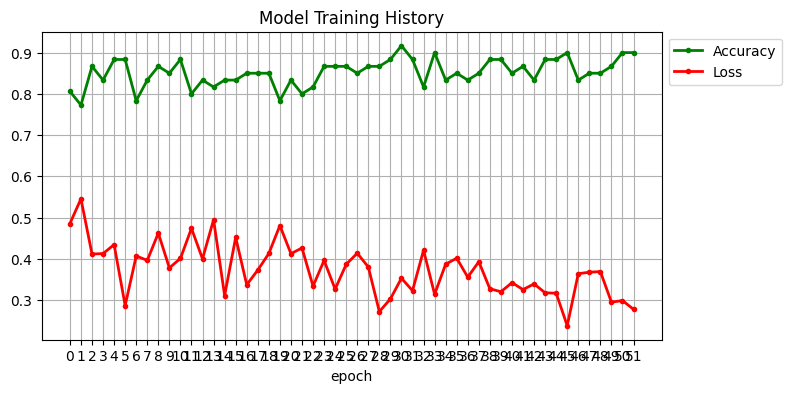

In [99]:
epochs = len(history.history['loss'])
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model



# 1. Prediction on test data
test_images = open_images(test_paths)  # Load and augment test images
test_labels_encoded = encode_label(test_labels,os.listdir(train_dir))  # Encode the test labels

# Predict using the trained model
test_predictions = model.predict(test_images)
predicted_classes = np.argmax(test_predictions, axis=1)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, predicted_classes))

42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 210ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.82      0.78       300
           1       0.70      0.46      0.56       306
           2       0.82      0.96      0.89       415
           3       0.90      0.92      0.91       310

    accuracy                           0.81      1331
   macro avg       0.79      0.79      0.78      1331
weighted avg       0.80      0.81      0.79      1331



Confusion Matrix:
[[246  41   3  10]
 [ 66 141  80  19]
 [  5   7 400   3]
 [ 12  11   2 285]]


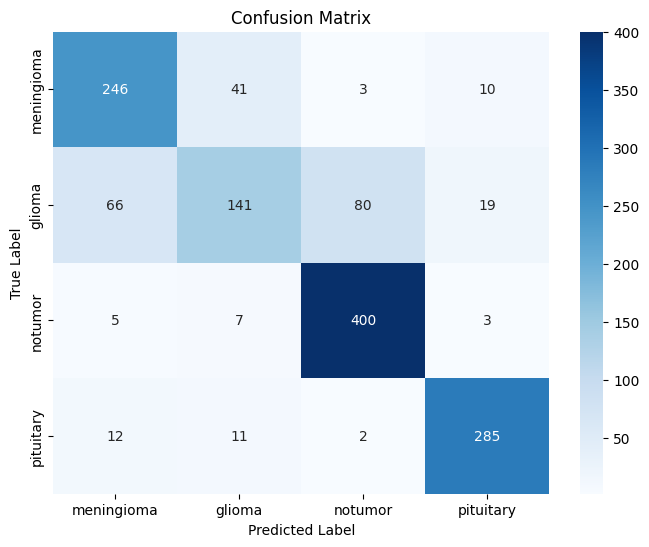

In [101]:
# 3. Confusion Matrix
cm = confusion_matrix(test_labels_encoded, predicted_classes)
print("Confusion Matrix:")
print(cm)
#plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

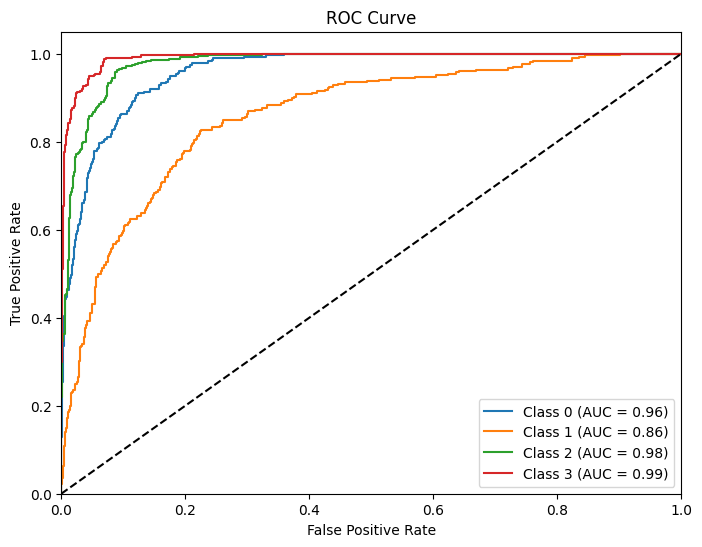

In [102]:
# 4. ROC Curve (for multi-class classification)
num_classes = len(os.listdir(train_dir))
test_labels_binarized = label_binarize(test_labels_encoded, classes=np.arange(num_classes))

# Compute ROC curve and AUC for each class
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(test_labels_binarized[:, i], test_predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [108]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

def detect_and_display(img_path, model, image_size=128):
    class_labels = sorted(os.listdir(train_dir))  # Ensure label order

    try:
        img = load_img(img_path, target_size=(image_size, image_size), color_mode="rgb")
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = predictions[0][predicted_class_index]

        result = "No Tumor" if class_labels[predicted_class_index] == 'notumor' else f"Tumor: {class_labels[predicted_class_index]}"

        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

In [109]:
from tensorflow.keras.models import load_model
# Save the entire model
model.save('/content/drive/MyDrive/Save Model/updatedModel1.h5')

In [110]:
from tensorflow.keras.models import load_model
# Load the trained model
model = load_model('/content/drive/MyDrive/Save Model/updatedModel1.h5')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


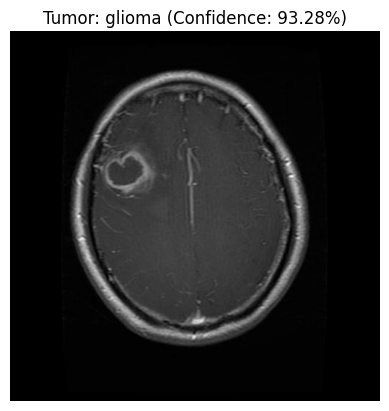

In [111]:
# Example usage
image_path = '/content/drive/MyDrive/tumor/Testing/glioma/Te-gl_0025.jpg'
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


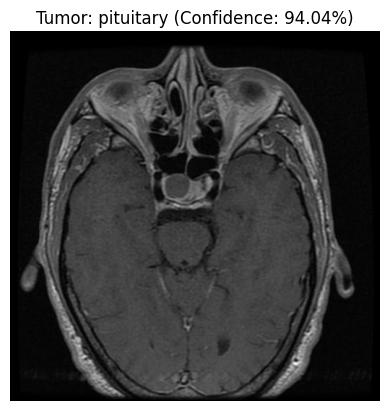

In [112]:
# Example usage
image_path = '/content/drive/MyDrive/tumor/Testing/pituitary/Te-pi_0030.jpg'
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


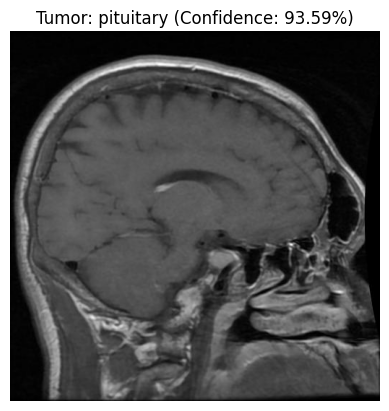

In [113]:
# Example usage
image_path = '/content/drive/MyDrive/tumor/Testing/pituitary/Te-pi_0282.jpg'
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


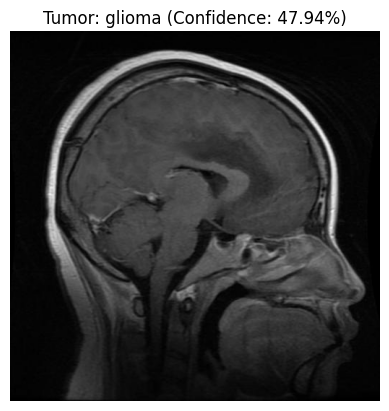

In [114]:
# Example usage
image_path = '/content/drive/MyDrive/tumor/Testing/glioma/Te-gl_0268.jpg'
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


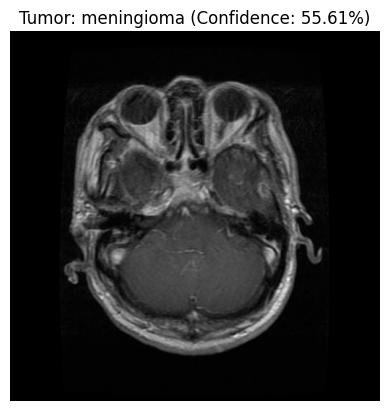

In [115]:
# Example usage
image_path = '/content/drive/MyDrive/tumor/Testing/glioma/Te-gl_0299.jpg'
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


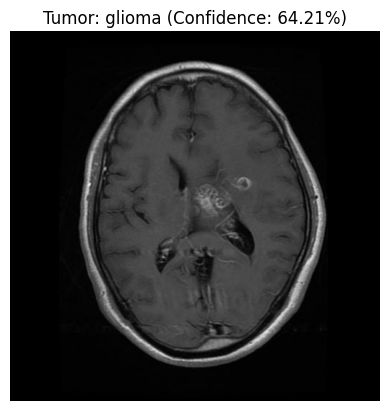

In [117]:
# Example usage
image_path = '/content/drive/MyDrive/tumor/Testing/glioma/Te-gl_0290.jpg'
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


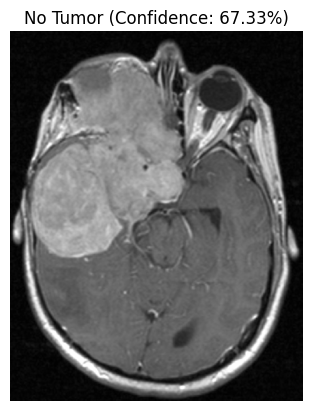

In [118]:
# Example usage
image_path = '/content/drive/MyDrive/tumor/Testing/meningioma/Te-me_0018.jpg'
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


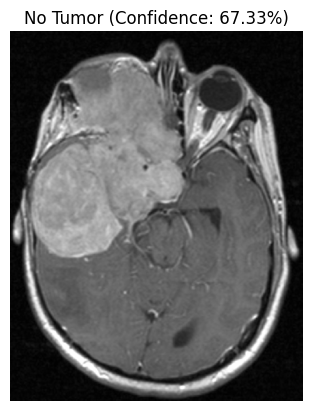

In [119]:
# Example usage
image_path = '/content/drive/MyDrive/tumor/Testing/meningioma/Te-me_0018.jpg'
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


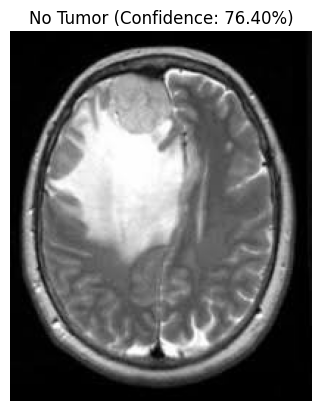

In [120]:
# Example usage
image_path = '/content/drive/MyDrive/tumor/Testing/meningioma/Te-me_0036.jpg'
detect_and_display(image_path, model)